## Visualization of training data
   
This notebook is used to visualize the training data. The data is stored in a hdf5 file. The file contains 200 simulations, each containing 99 simulation steps from $t=0.0$ until $t=0.98$ with $\Delta t = 0.01$.

In [7]:
import h5py
import numpy as np

from matplotlib import pyplot as plt

# location of training data
DATA_FILE = "github/smdp/buoyancy-flow/data/smoke_plumes_r0.h5"

# visualize data index 5
idx = 5
DT = 0.01

### Load data

Each simulation is comprised of the following fields:   
- `smoke`: smoke density / marker field - (99, 64, 64)
- `velocity_x`: velocity in x-direction - (99, 64, 63)
- `velocity_y`: velocity in y-direction - (99, 63, 64)
- `mask`: mask field for obstacles - (99, 64, 64)


In [2]:
with h5py.File(DATA_FILE, 'r') as f:

    group_selector = f[str(idx)]
   
    smoke = np.flip(group_selector['smoke'][:], axis=1)
    velocity_x = np.flip(group_selector['velocity_x'][:], axis=1)
    velocity_y = np.flip(group_selector['velocity_y'][:], axis=1)
    mask = np.flip(group_selector['mask'][:], axis=1) 

### Visualize data velocity and smoke/marker field

Visualize marker field and velocity in x direction at time step 0 and time step 60. The mask field is visualized as well. The mask field is to show the obstacles.

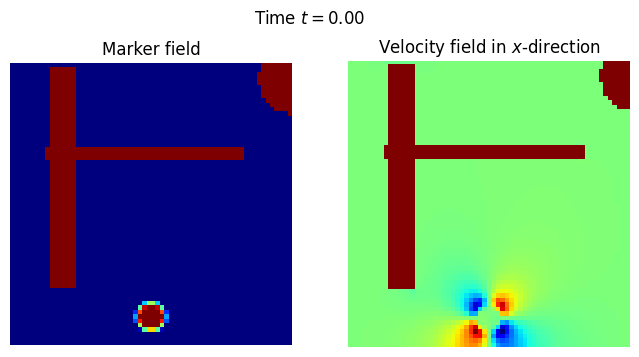

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) 

time_step = 0

vmin = np.min(smoke[time_step])
vmax = np.max(smoke[time_step])
smoke_with_mask = smoke[time_step] + (1-mask[0]) * vmax
axes[0].imshow(smoke_with_mask, cmap='jet', vmin = vmin, vmax = vmax)
axes[0].set_axis_off()
axes[0].set_title('Marker field')   

vmin = np.min(velocity_x[time_step])
vmax = np.max(velocity_x[time_step])
vel_x_with_mask = velocity_x[time_step] + (1-mask[0][:, :-1]) * vmax
axes[1].imshow(vel_x_with_mask, cmap='jet', vmin = vmin, vmax = vmax)
axes[1].set_axis_off()
axes[1].set_title(r'Velocity field in $x$-direction')

fig.suptitle(r'' + f'Time $t={time_step * DT:.2f}$')

plt.show()

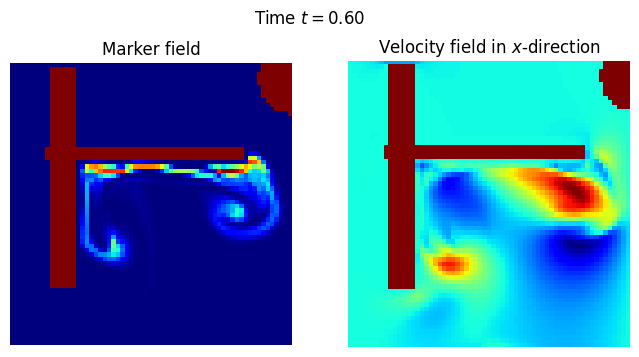

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) 

time_step = 60

vmin = np.min(smoke[time_step])
vmax = np.max(smoke[time_step])
smoke_with_mask = smoke[time_step] + (1-mask[0]) * vmax
axes[0].imshow(smoke_with_mask, cmap='jet', vmin = vmin, vmax = vmax)
axes[0].set_axis_off()
axes[0].set_title('Marker field')   

vmin = np.min(velocity_x[time_step])
vmax = np.max(velocity_x[time_step])
vel_x_with_mask = velocity_x[time_step] + (1-mask[0][:, :-1]) * vmax
axes[1].imshow(vel_x_with_mask, cmap='jet', vmin = vmin, vmax = vmax)
axes[1].set_axis_off()
axes[1].set_title(r'Velocity field in $x$-direction')

fig.suptitle(r'' + f'Time $t={time_step * DT:.2f}$')

plt.show()

### Create video animation of marker and velocity fields

First setup a function to create a video animation of the marker and velocity fields. The function takes the marker and velocity fields as input and creates a video animation of the fields. The video is saved as `videos/{idx}.mp4`.

In [9]:
# location where the video is saved
savename = f'github/smdp/buoyancy-flow/data/videos/simulation_{idx}'

In [24]:
import moviepy.editor as mp

def save_smoke_video(smoke_list, velocity_list_x, velocity_list_y, mask_list, savename):
    
    def get_image(smoke, velocity_x, velocity_y, mask, title, color_clip_dict):
        
        height = 4
        width = 12
        dpi = 100
        
        scale_factor = 0.5
        
        gs_kw = dict(width_ratios=[1, 1, 1], height_ratios=[1])
        fig, axd = plt.subplot_mosaic([[0,1,2]],
                                  gridspec_kw=gs_kw, figsize=(width, height),
                                  constrained_layout=True)
        
        fig.set_dpi(dpi)
       
        smoke_display = smoke + scale_factor * (1-mask) * color_clip_dict['smoke'][1]  
        axd[0].imshow(smoke_display, cmap='viridis', vmin=color_clip_dict['smoke'][0], vmax=color_clip_dict['smoke'][1])
        axd[0].set_aspect('auto')
        axd[0].set_axis_off()
        axd[0].set_title('Marker field')
        
        velocity_x_display = velocity_x + scale_factor * (1-mask[:, :-1]) * color_clip_dict['velocity'][1]  
        axd[1].imshow(velocity_x_display, cmap='jet', vmin=color_clip_dict['velocity'][0], vmax=color_clip_dict['velocity'][1])
        axd[1].set_aspect('auto')
        axd[1].set_axis_off()
        axd[1].set_title(r'Velocity ($x$-direction)')
        
        velocity_y_display = velocity_y + scale_factor * (1-mask[:-1, :]) * color_clip_dict['velocity'][1]
        axd[2].imshow(velocity_y_display, cmap='jet', vmin=color_clip_dict['velocity'][0], vmax=color_clip_dict['velocity'][1])
        axd[2].set_aspect('auto')
        axd[2].set_axis_off()
        axd[2].set_title(r'Velocity ($y$-direction)')
        
        plt.suptitle(title)
        
        plt.tight_layout()

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        
        plt.close(fig)
        
        return image.reshape(dpi * height, dpi * width, 3)
    
    images = []
    DT = 0.01
    
    vmin_vel = min(np.min(velocity_list_x), np.min(velocity_list_y))
    vmax_vel = max(np.max(velocity_list_x), np.max(velocity_list_y))    
    
    vmin_smoke = np.min(smoke_list)
    vmax_smoke = np.max(smoke_list) 
    
    color_clip_dict = {'smoke': (vmin_smoke, vmax_smoke), 'velocity': (vmin_vel, vmax_vel)} 
    
    for i in range(len(smoke_list)):
        plot_title = r'' + f'Time t=${i * DT:.2f}$'   
        images.append(get_image(smoke_list[i], velocity_list_x[i], velocity_list_y[i], mask_list[i], plot_title, 
                      color_clip_dict=color_clip_dict))
        
    for i in range(10):
        images.append(images[-1])
    
    clip = mp.ImageSequenceClip(images, fps=8)
    
    clip.write_videofile(f'{savename}.mp4', fps=8)
    
images = save_smoke_video(list(smoke), list(velocity_x), list(velocity_y), list(mask), savename)

Moviepy - Building video github/smdp/buoyancy-flow/data/videos/simulation_5.mp4.
Moviepy - Writing video github/smdp/buoyancy-flow/data/videos/simulation_5.mp4


Moviepy - Done !
Moviepy - video ready github/smdp/buoyancy-flow/data/videos/simulation_5.mp4
